# Linear uncertainty propagation

🚧 Work in progress

See [Measurements.jl](https://github.com/JuliaPhysics/Measurements.jl) for further reference.

In [8]:
!wget -O ct.jpg https://upload.wikimedia.org/wikipedia/commons/7/77/CT_of_sclerotic_lesions_in_the_skull_in_renal_osteodystrophy.jpg

--2021-12-02 21:19:56--  https://upload.wikimedia.org/wikipedia/commons/7/77/CT_of_sclerotic_lesions_in_the_skull_in_renal_osteodystrophy.jpg
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17741 (17K) [image/jpeg]
Saving to: ‘ct.jpg’

ct.jpg              100%[===================>]  17.33K  --.-KB/s    in 0.008s  

2021-12-02 21:19:57 (2.15 MB/s) - ‘ct.jpg’ saved [17741/17741]



In [9]:
import numpy as np
from jax import numpy as jnp
from jax import random, nn, value_and_grad, jit, grad, vmap
from jax import lax
from jax.example_libraries import optimizers
from functools import partial
from tqdm import tqdm
from matplotlib import pyplot as plt
from luprox import linear_uncertainty, mc_uncertainty

from jwave.geometry import Domain, Medium, TimeAxis, Sources, _circ_mask, _points_on_circle, Sensors
from jwave.signal_processing import gaussian_window, apply_ramp, smooth, analytic_signal
from jwave.acoustics import ongrid_wave_propagation

In [10]:
import cv2

# load image as gray scale and convert to numpy
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Rescale image to 192x192
    img = cv2.resize(img, (192, 192))

    # Convert to numpy array
    img = np.asarray(img)
    img = img/255.
    img[img<0.4] = 0.

    # pad image to 256 symmetric
    img = np.pad(img, ((32, 32), (32, 32)), 'constant', constant_values=(0, 0))

    return img

img = read_img("./ct.jpg")

In [11]:
img.shape

(256, 256)

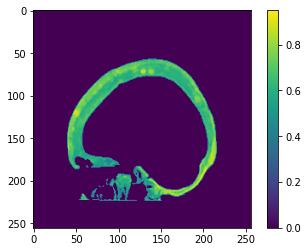

In [12]:
plt.imshow(img)
plt.colorbar()

In [13]:
# Settings
N = (256, 256)
dx = (.5, .5)
cfl = 0.3
num_sources = 16
source_freq = .5
source_mag = 5
random_seed = random.PRNGKey(42)

# Define domain
domain = Domain(N, dx)

# Define medium
sound_speed = img + 1

medium = Medium(domain=domain, sound_speed=sound_speed, density=jnp.ones(N),
    attenuation=0.0, pml_size=20.)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl, t_end=120.)

# Sources
source_mag = source_mag/time_axis.dt
t = time_axis.to_array()
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 5, 2)
x, y = _points_on_circle(num_sources,110,(128,128))
source_positions = (jnp.array(x), jnp.array(y))

src_signal = jnp.stack([signal]*num_sources)
sources = Sources(source_positions, src_signal)

In [14]:
time_axis

TimeAxis(dt=0.07696177810430527, t_end=120.0)

In [15]:
from jwave.acoustics import ongrid_simple_wave_propagation
# Run simulations
params, solver = ongrid_simple_wave_propagation(
    medium=medium,
    time_array=time_axis,
    sources=sources,
    output_t_axis = time_axis,
    backprop=True,
    checkpoint=True
)

In [16]:
params["source_signals"].shape

(16, 1560)

In [17]:
params["acoustic_params"]["speed_of_sound"].shape

(256, 256, 1)

In [18]:
def get_field(bone_sos):
    sound_speed = img*bone_sos + 1
    
    new_params = params.copy()
    new_params["acoustic_params"]["speed_of_sound"] = jnp.expand_dims(sound_speed,-1)
    
    p = solver(new_params)
    return p[100::5]

In [19]:
p = get_field(.7)

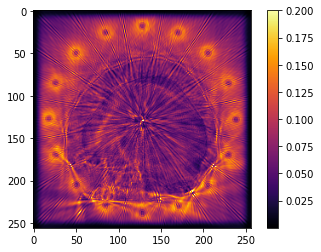

In [20]:
from jwave.utils import show_field
plt.imshow(jnp.mean(jnp.abs(p**2),0), cmap="inferno", vmax=0.2)
plt.colorbar()

In [21]:
get_field_lup = linear_uncertainty(get_field)
x = jnp.array([1.])
covariance = jnp.array([[(0.05)**2]])
mu_linear, cov_linear = get_field_lup(x, covariance)

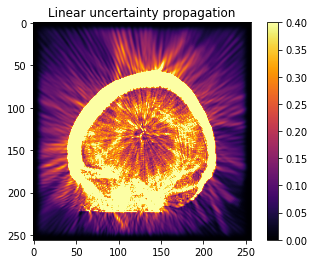

In [22]:
plt.imshow(jnp.mean(cov_linear,0), cmap="inferno", vmin=0., vmax=.4)
plt.title("Linear uncertainty propagation")
plt.colorbar()

In [23]:
from jax import random

get_field_lup = mc_uncertainty(get_field, 20)
mu_mc, cov_mc = get_field_lup(x, covariance, random.PRNGKey(0))

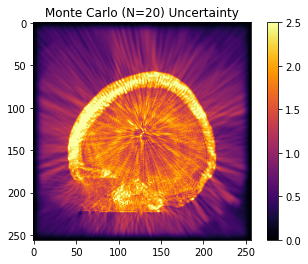

In [68]:
plt.imshow(jnp.sqrt(jnp.sum(jnp.abs(cov_mc),0)), cmap="inferno", vmin=0., vmax=2.5)
plt.title("Monte Carlo (N=20) Uncertainty")
plt.colorbar()